#Importing Libraries

In [ ]:
!pip install ppscore sweetviz missingno optuna

In [1]:
import optuna
import warnings
import numpy as np
import pandas as pd
import sweetviz as sv
import ppscore as pps
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

from IPython.core.display import display, HTML

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Data Exploration

In [2]:
data=pd.read_csv('/content/drive/MyDrive/ML_data/Loan/data.csv')

In [ ]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [ ]:
data.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

# Data Visualization

In [ ]:
# This step generates a detailed report of the dataset
report = sv.analyze(data)

# Show the generated Sweetviz report as an HTML
report.show_html('Report.html')

# Open the generated HTML report and read its content
with open('Report.html', 'r') as f:
    html_content = f.read()

In [ ]:
# Display the HTML content in the notebook
display(HTML(html_content))

In [ ]:
# Calculate the Predictive Power Score (PPS) matrix for the dataset
pps_matrix = pps.matrix(data)

In [ ]:
pps_matrix_pivot = pps_matrix.pivot(index='x', columns='y', values='ppscore')

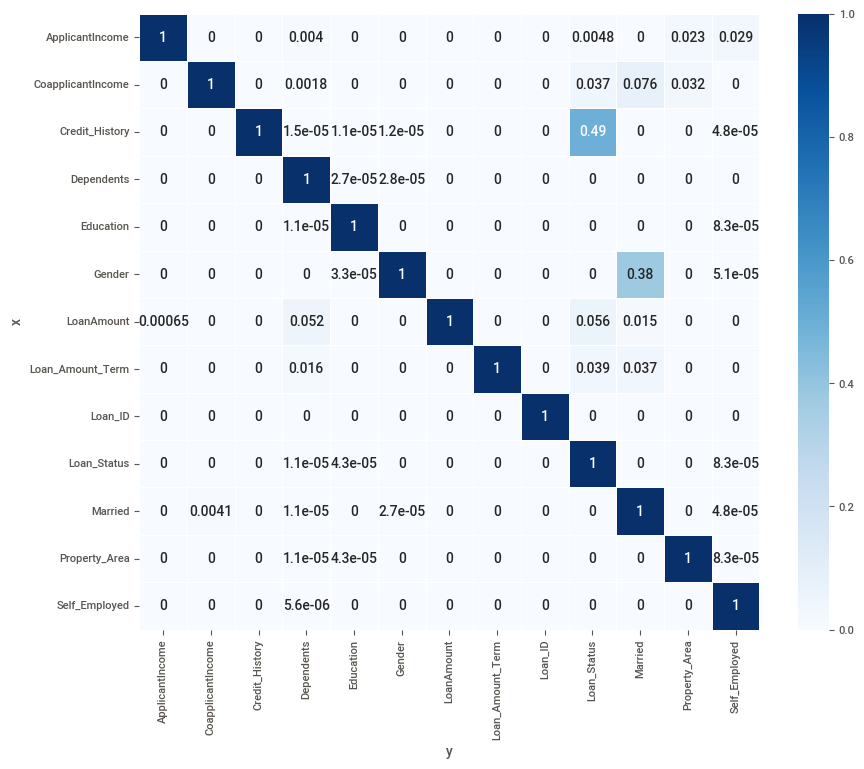

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(pps_matrix_pivot, vmin=0, vmax=1, cmap='Blues', linewidths=0.5, annot=True)
plt.show()

In [ ]:
data.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

<Axes: >

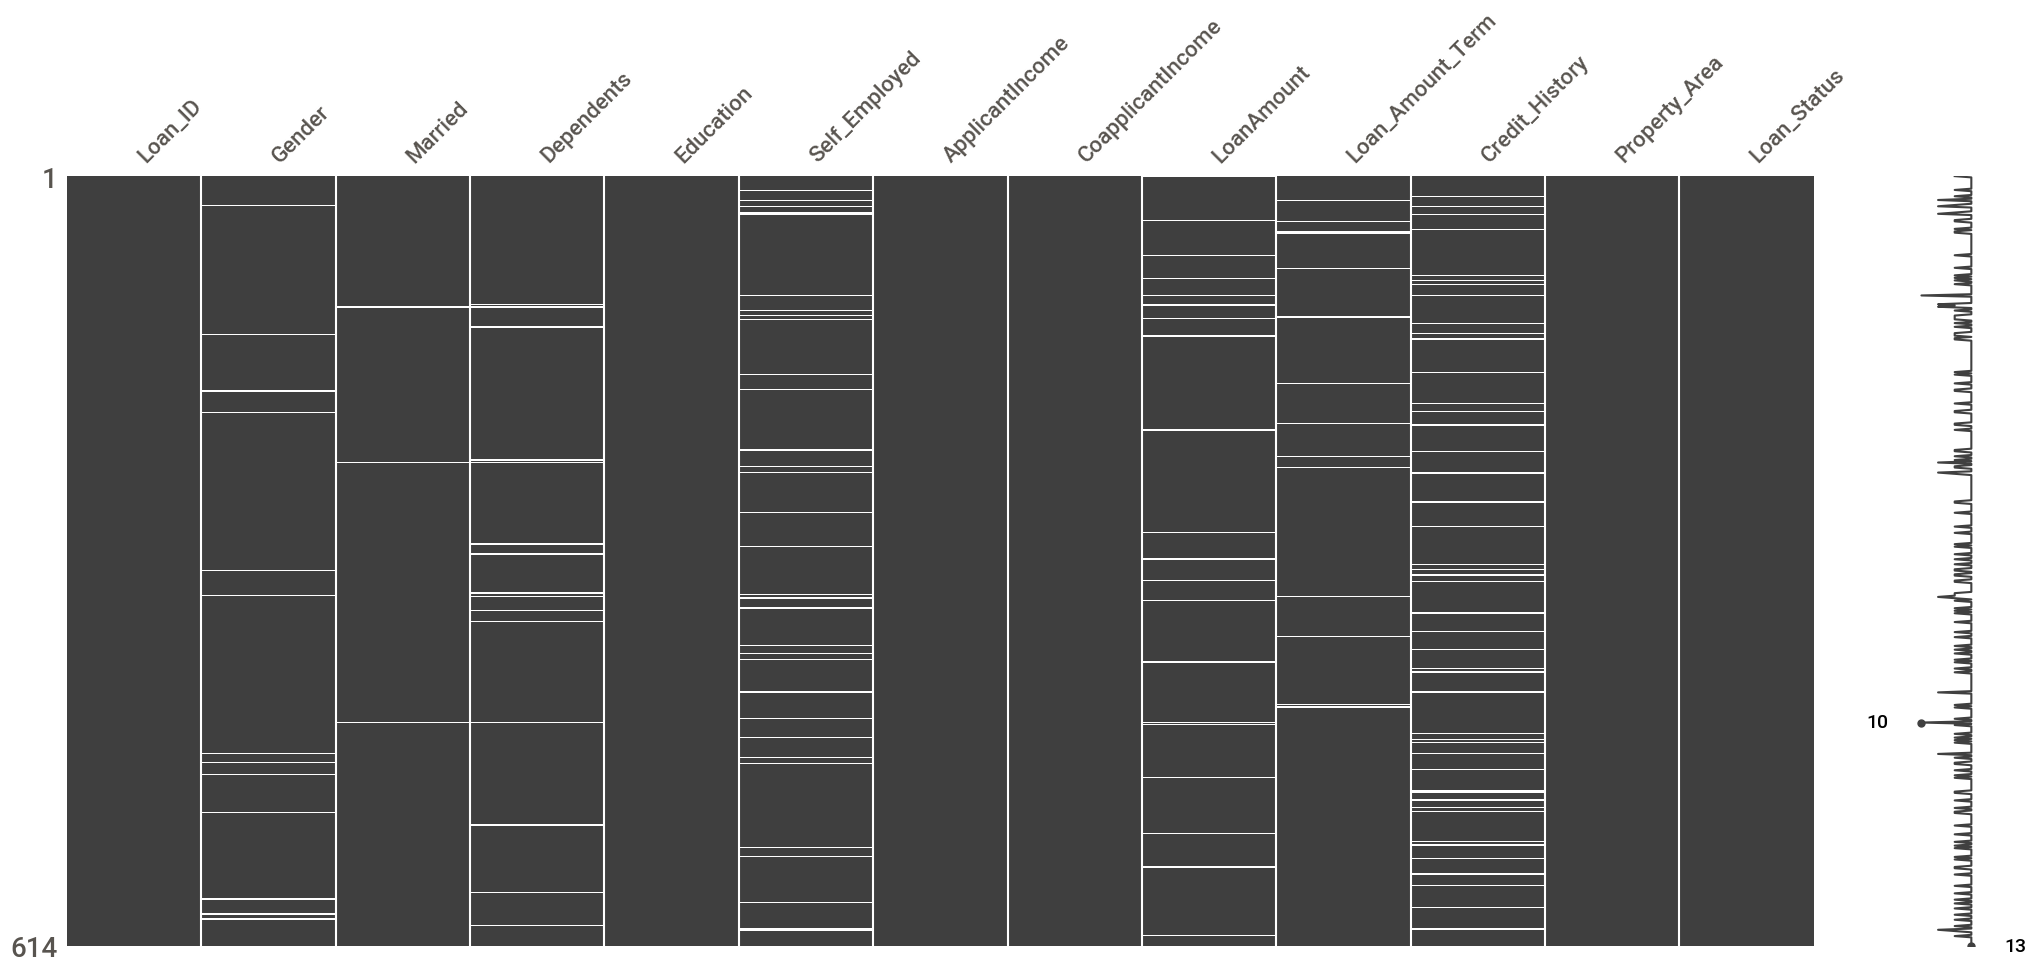

In [ ]:
# Visualize the matrix of missing values
msno.matrix(data)

<Axes: >

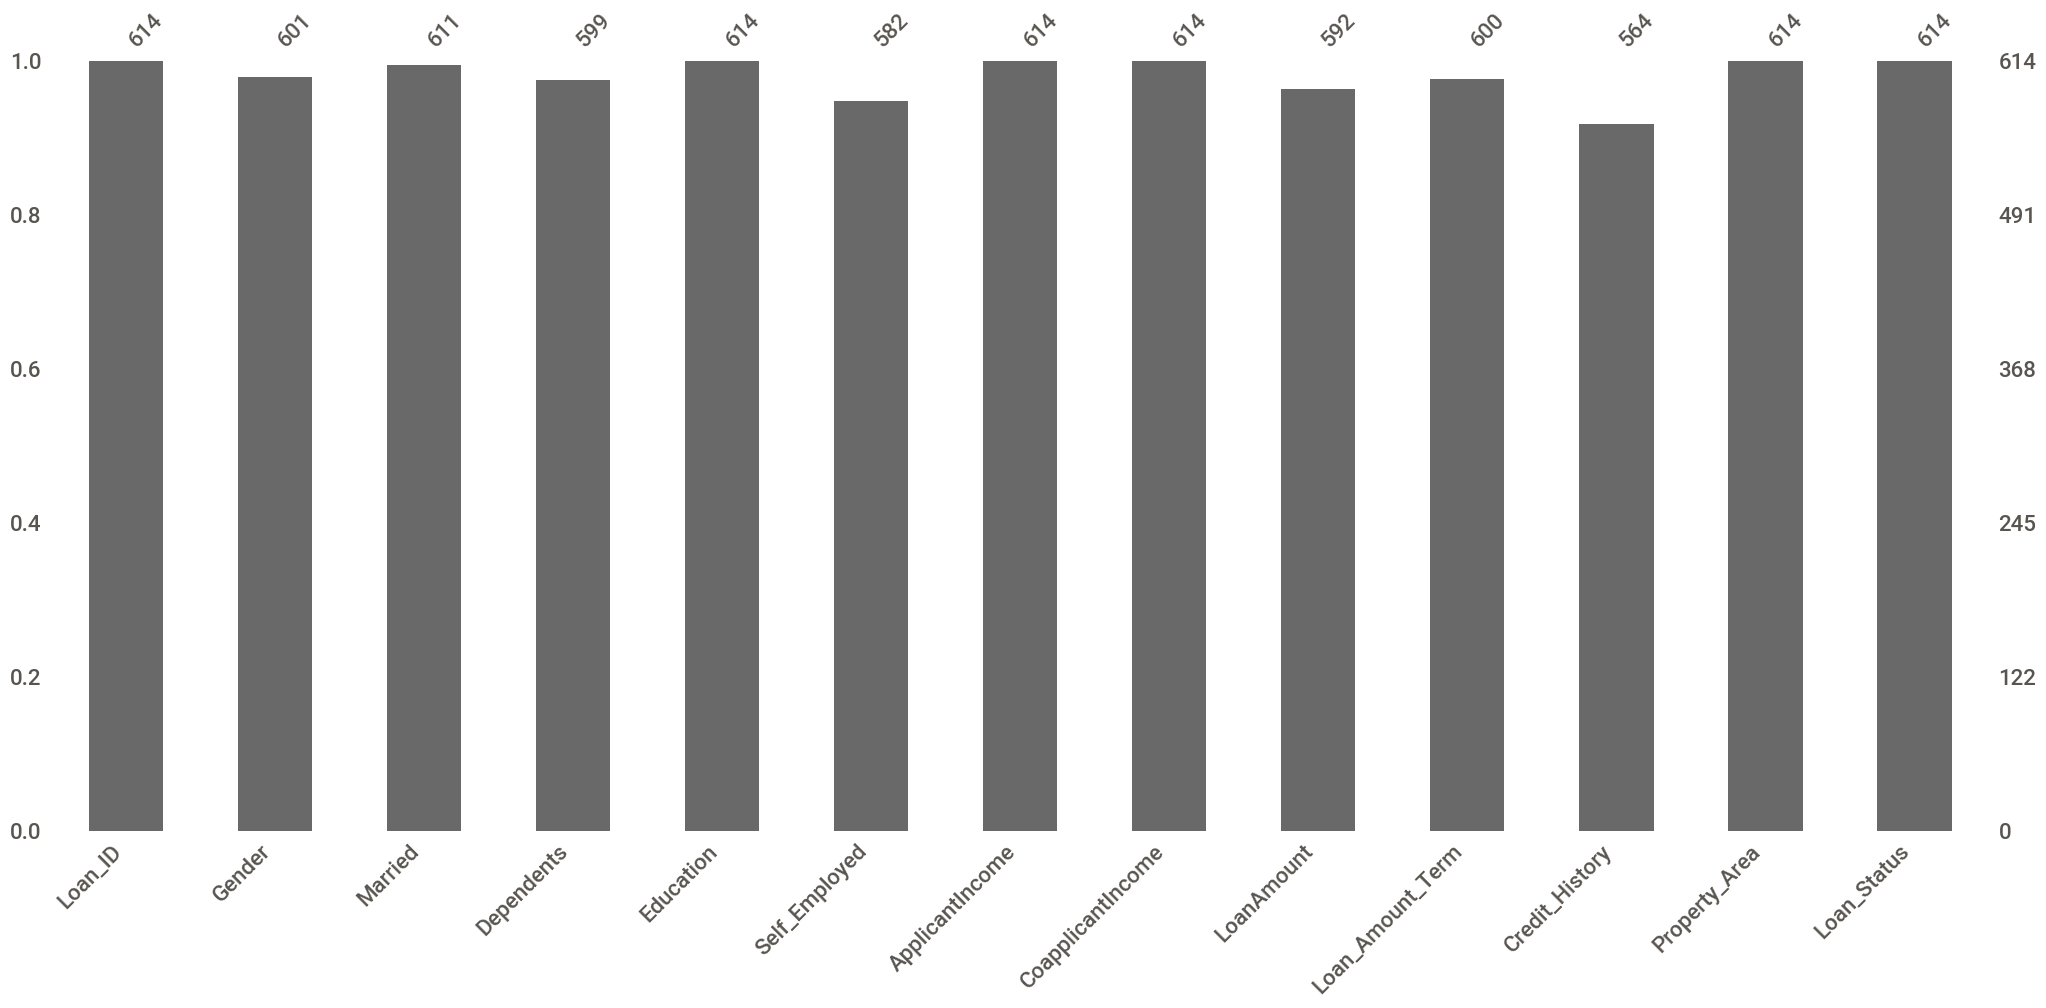

In [ ]:
msno.bar(data)

<Axes: >

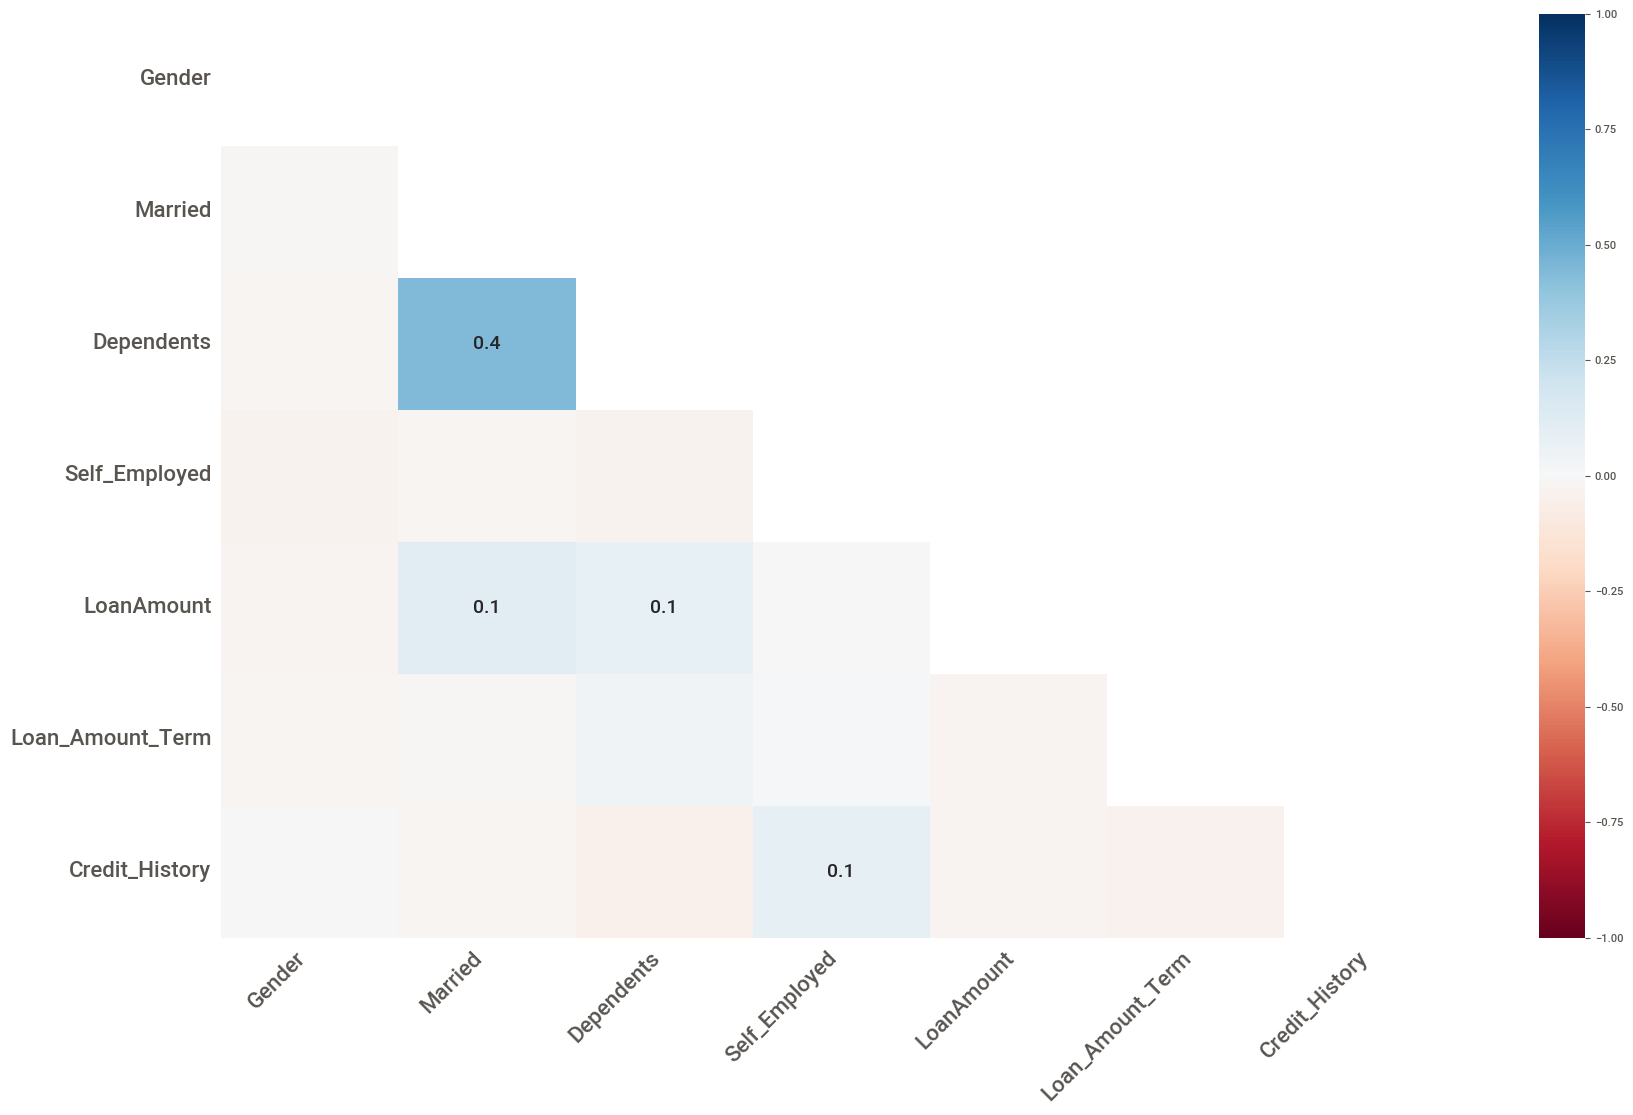

In [ ]:
#It helps you identify if missing values in different columns are correlated
msno.heatmap(data)

# Data Preprocessing

In [ ]:
# Create a copy of the DataFrame to work on
df_copy = data.copy()

In [ ]:
# Identify rows with the most missing values
df_copy['missing_count'] = df_copy.isnull().sum(axis=1)
df_sorted_by_missing = df_copy.sort_values(by='missing_count', ascending=False)
print(df_sorted_by_missing.head())

      Loan_ID  Gender Married Dependents Education Self_Employed  \
95   LP001326    Male      No          0  Graduate           NaN   
435  LP002393  Female     NaN        NaN  Graduate            No   
236  LP001786    Male     Yes          0  Graduate           NaN   
24   LP001052    Male     Yes          1  Graduate           NaN   
30   LP001091    Male     Yes          1  Graduate           NaN   

     ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
95              6782                0.0         NaN             360.0   
435            10047                0.0         NaN             240.0   
236             5746                0.0       255.0             360.0   
24              3717             2925.0       151.0             360.0   
30              4166             3369.0       201.0             360.0   

     Credit_History Property_Area Loan_Status  missing_count  
95              NaN         Urban           N              3  
435             1.0     Se

In [ ]:
# Drop these rows from the copy of the DataFrame
data = df_copy[df_copy['missing_count'] != 3].drop(columns=['missing_count'])

In [ ]:
data.shape

(612, 13)

In [ ]:
# Fill missing values with the mode for each categorical column
data['Gender'].fillna(data['Gender'].mode()[0], inplace=True)
data['Married'].fillna(data['Married'].mode()[0], inplace=True)
data['Dependents'].fillna(data['Dependents'].mode()[0], inplace=True)
data['Self_Employed'].fillna(data['Self_Employed'].mode()[0], inplace=True)
data['Credit_History'].fillna(data['Credit_History'].mode()[0], inplace=True)
data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].mode()[0], inplace=True)

In [ ]:
# Fill missing values with the mean for the numerical column
data['LoanAmount'].fillna(data['LoanAmount'].mean(),inplace=True)

In [ ]:
# Drop the 'Loan_ID' column from the dataset
data.drop(['Loan_ID'], axis=1, inplace=True)

In [ ]:
# Convert binary categorical columns to 0s and 1s
categorical_columns = ['Gender', 'Married', 'Education', 'Self_Employed', 'Loan_Status']
for column in categorical_columns:
    data[column] = pd.get_dummies(data[column], drop_first=True)

In [ ]:
# Convert Multi class categorical columns using One Hot Encoding
multi_categorical_columns = ['Dependents', 'Property_Area']
data = pd.get_dummies(data, columns=multi_categorical_columns)

In [ ]:
data.head()

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,1,0,0,0,5849,0.0,146.412162,360.0,1.0,1,1,0,0,0,0,0,1
1,1,1,0,0,4583,1508.0,128.000000,360.0,1.0,0,0,1,0,0,1,0,0
2,1,1,0,1,3000,0.0,66.000000,360.0,1.0,1,1,0,0,0,0,0,1
3,1,1,1,0,2583,2358.0,120.000000,360.0,1.0,1,1,0,0,0,0,0,1
4,1,0,0,0,6000,0.0,141.000000,360.0,1.0,1,1,0,0,0,0,0,1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 612 entries, 0 to 613
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   612 non-null    uint8  
 1   Married                  612 non-null    uint8  
 2   Education                612 non-null    uint8  
 3   Self_Employed            612 non-null    uint8  
 4   ApplicantIncome          612 non-null    int64  
 5   CoapplicantIncome        612 non-null    float64
 6   LoanAmount               612 non-null    float64
 7   Loan_Amount_Term         612 non-null    float64
 8   Credit_History           612 non-null    float64
 9   Loan_Status              612 non-null    uint8  
 10  Dependents_0             612 non-null    uint8  
 11  Dependents_1             612 non-null    uint8  
 12  Dependents_2             612 non-null    uint8  
 13  Dependents_3+            612 non-null    uint8  
 14  Property_Area_Rural      6

In [ ]:
# Selecting all columns except 'Loan_Status' as features
X = data.drop(columns=['Loan_Status'])  # Feature matrix

# Selecting 'Loan_Status' as the target variable
y = data['Loan_Status']  # Target vector

In [ ]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

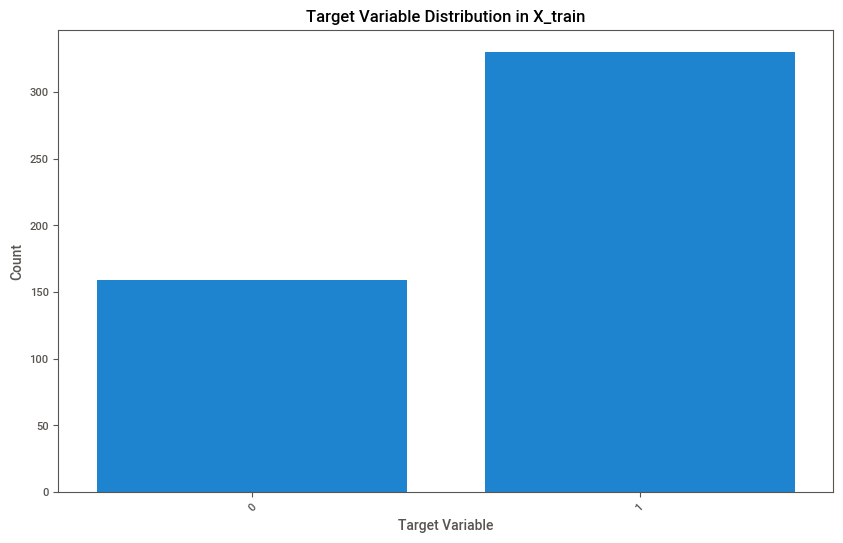

In [ ]:
# Plotting the target variable distribution in X_train
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train)
plt.title('Target Variable Distribution in X_train')
plt.xlabel('Target Variable')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

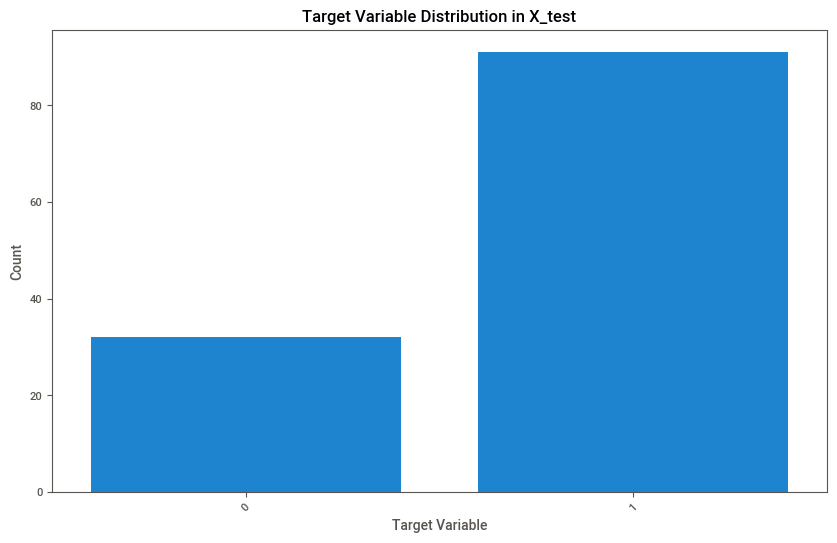

In [ ]:
# Plotting the target variable distribution in X_test
plt.figure(figsize=(10, 6))
sns.countplot(x=y_test)
plt.title('Target Variable Distribution in X_test')
plt.xlabel('Target Variable')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Apply SMOTE only on the training data to fix skewed data problem
smote = SMOTE(random_state=42)
X_train, y_train= smote.fit_resample(X_train, y_train)

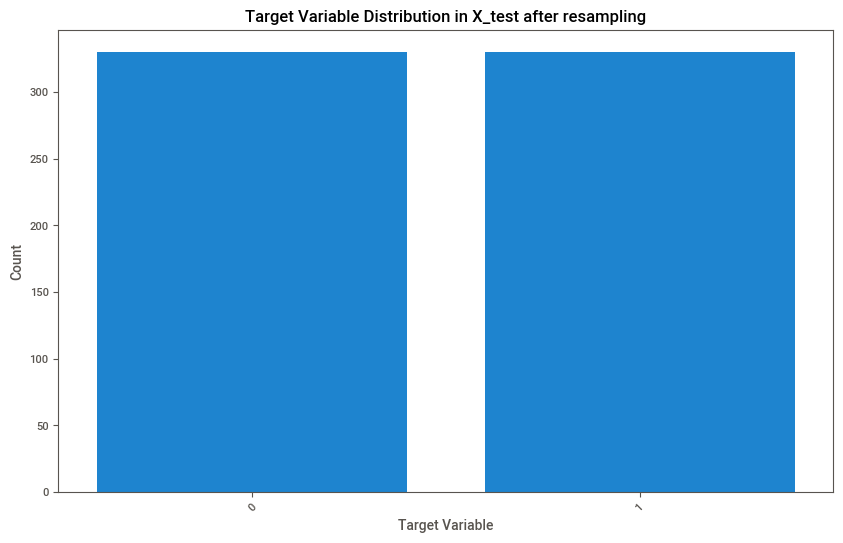

In [ ]:
# Plotting the target variable distribution in X_test
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train)
plt.title('Target Variable Distribution in X_test after resampling')
plt.xlabel('Target Variable')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
X_train.shape

(660, 16)

In [ ]:
# Initialize the class
scaler_linear = StandardScaler()

# Compute the mean and standard deviation of the training set then transform it
X_train = scaler_linear.fit_transform(X_train)

In [ ]:
X_test = scaler_linear.transform(X_test)

# Model Selection

In [ ]:
# Initializing the model
logreg = LogisticRegression()

# Training the model
logreg.fit(X_train, y_train)

# Predicting on the test set
y_pred = logreg.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

print("Logistic Regression Model:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Logistic Regression Model:
Accuracy: 0.8374
Precision: 0.8447
Recall: 0.9560
F1 Score: 0.8969


In [ ]:
# Initializing the model
svc = SVC()

# Training the model
svc.fit(X_train, y_train)

# Predicting on the test set
y_pred = svc.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

print("\nSupport Vector Classifier:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



Support Vector Classifier:
Accuracy: 0.8374
Precision: 0.8318
Recall: 0.9780
F1 Score: 0.8990


In [ ]:
# Initializing the model
rf = RandomForestClassifier(random_state=42)

# Training the model
rf.fit(X_train, y_train)

# Predicting on the test set
y_pred = rf.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

print("\nRandom Forest Classifier:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



Random Forest Classifier:
Accuracy: 0.7886
Precision: 0.8351
Recall: 0.8901
F1 Score: 0.8617


In [ ]:
# Initializing the model
xgb = XGBClassifier(random_state=42)

# Training the model
xgb.fit(X_train, y_train)

# Predicting on the test set
y_pred = xgb.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

print("\nXGBoost Classifier:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



XGBoost Classifier:
Accuracy: 0.8293
Precision: 0.8646
Recall: 0.9121
F1 Score: 0.8877


In [ ]:
# Initializing the model
gb = GradientBoostingClassifier(random_state=42)

# Training the model
gb.fit(X_train, y_train)

# Predicting on the test set
y_pred = gb.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

print("\nGradient Boosting Classifier:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



Gradient Boosting Classifier:
Accuracy: 0.8049
Precision: 0.8252
Recall: 0.9341
F1 Score: 0.8763


In [ ]:
# Initializing the model
nb = GaussianNB()

# Training the model
nb.fit(X_train, y_train)

# Predicting on the test set
y_pred = nb.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

print("\nNaive Bayes Classifier (GaussianNB):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



Naive Bayes Classifier (GaussianNB):
Accuracy: 0.7805
Precision: 0.8478
Recall: 0.8571
F1 Score: 0.8525


# Model Tuning

In [ ]:
# Define the expanded parameter grid for SVC
param_grid_svc = {
    'C': [10, 100, 200],
    'gamma': [2, 1, 0.1],
    'kernel': ['rbf', 'poly', 'sigmoid', 'linear'],
    'probability': [True],
}

# Initialize the SVC model
svc = SVC()

# Initialize GridSearchCV with SVC
grid_search_svc = GridSearchCV(estimator=svc, param_grid=param_grid_svc, scoring='accuracy', cv=5, verbose=2)

# Fit the model with the grid search
grid_search_svc.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters for SVC: ", grid_search_svc.best_params_)
print("Best score for SVC: ", grid_search_svc.best_score_)

# Test the best model on the test set
best_svc = grid_search_svc.best_estimator_
svc_test_score = best_svc.score(X_test, y_test)
print("Test score for the best SVC model: ", svc_test_score)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END ........C=10, gamma=2, kernel=rbf, probability=True; total time=   0.2s
[CV] END ........C=10, gamma=2, kernel=rbf, probability=True; total time=   0.1s
[CV] END ........C=10, gamma=2, kernel=rbf, probability=True; total time=   0.2s
[CV] END ........C=10, gamma=2, kernel=rbf, probability=True; total time=   0.1s
[CV] END ........C=10, gamma=2, kernel=rbf, probability=True; total time=   0.2s
[CV] END .......C=10, gamma=2, kernel=poly, probability=True; total time=   0.4s
[CV] END .......C=10, gamma=2, kernel=poly, probability=True; total time=   0.7s
[CV] END .......C=10, gamma=2, kernel=poly, probability=True; total time=   1.4s
[CV] END .......C=10, gamma=2, kernel=poly, probability=True; total time=   1.8s
[CV] END .......C=10, gamma=2, kernel=poly, probability=True; total time=   2.5s
[CV] END ....C=10, gamma=2, kernel=sigmoid, probability=True; total time=   0.2s
[CV] END ....C=10, gamma=2, kernel=sigmoid, pro

In [ ]:
# Define the parameter grid for RandomForest
param_grid_rf = {
    'n_estimators': [25, 50, 100],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'max_depth': [4, 6, 8],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False],
    'min_samples_leaf': [1, 2, 4],
}

# Initialize the RandomForestClassifier model
rf = RandomForestClassifier()

# Initialize GridSearchCV with RandomForestClassifier
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, scoring='accuracy', cv=5, verbose=2)

# Fit the model with the grid search
grid_search_rf.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters for RandomForest: ", grid_search_rf.best_params_)
print("Best score for RandomForest: ", grid_search_rf.best_score_)

# Test the best model on the test set
best_rf = grid_search_rf.best_estimator_
rf_test_score = best_rf.score(X_test, y_test)
print("Test score for the best RandomForest model: ", rf_test_score)


Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[CV] END bootstrap=True, criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   0.0s
[CV] END bootstrap=True, criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, criterion=g

In [ ]:
warnings.filterwarnings('ignore')

# Define the parameter grid for Logistic Regression
param_grid_lr = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 500, 1000]
}

# Initialize the Logistic Regression model
lr = LogisticRegression()

# Initialize GridSearchCV with Logistic Regression
grid_search_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr, scoring='accuracy', cv=5,verbose=2)

# Fit the model with the grid search
grid_search_lr.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters for Logistic Regression: ", grid_search_lr.best_params_)
print("Best score for Logistic Regression: ", grid_search_lr.best_score_)

# Test the best model on the test set
best_lr = grid_search_lr.best_estimator_
lr_test_score = best_lr.score(X_test, y_test)
print("Test score for the best Logistic Regression model: ", lr_test_score)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits
[CV] END C=0.001, max_iter=100, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.001, max_iter=100, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.001, max_iter=100, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.001, max_iter=100, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.001, max_iter=100, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ....C=0.001, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....C=0.001, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....C=0.001, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....C=0.001, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....C=0.001, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.001, max_iter=100, penalty=l1, s

# Ensemble

In [ ]:
# Create a voting classifier with soft voting including Logistic Regression, Random Forest, and SVC
voting_clf = VotingClassifier(estimators=[
    ('rf', best_rf),
    ('svc', best_svc),
    ('lr', best_lr)
], voting='soft')

# Train the voting classifier
voting_clf.fit(X_train, y_train)

# Predicting on the test set
y_pred = voting_clf.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

print("\nVoting Classifier:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



Voting Classifier:
Accuracy: 0.8537
Precision: 0.8411
Recall: 0.9890
F1 Score: 0.9091


# Final Results

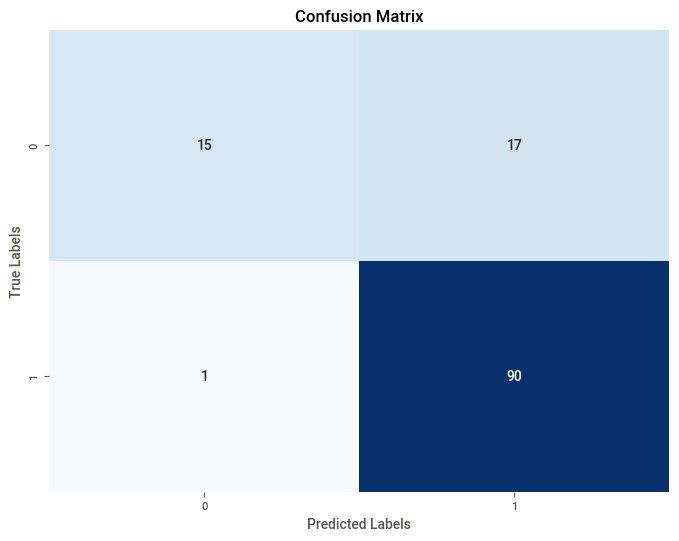

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
